# Data Analysis and Plots for Exploration

The following notebook contains code to analyze and plot data for benzyl chloride hydrolysis. The data is from...

"Changes in mechanism and transition state structure for solvolysis reactions of ring substituted benzyl chlorides in aqueous solution." P.E. Yeary, J.P. Richard, *J. Phys. Org. Chem.*, **2024**, *37*, e4600. https://doi.org/10.1002/poc.4600 

## Load Data Set

First let us load the data.

In [149]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

from uncertainties import unumpy as unp
import uncertainties as un

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches




github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Explorations/data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

github_location = "data/"
github_location_styles = "~/github/LFER-QSAR/styles/"
github_location_LFER_tables = "~/github/LFER-QSAR/data/"



sigmatype = "s_plus"          # sigmatype can be one of ["sigma", "s_plus", "s_minus"]



################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df1 = pd.read_csv(github_location + "Table_1_2.csv",
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Designation", 
                 comment = "#") 

#df1.insert(3, "Total_Sigma", np.NaN, allow_duplicates = False)     # Insert a column for the total sigma value

display(df1.head())

,Description,para,sub1,sub2,kobs,MeOH/TFE,MeOH/H2O,H_2O/TFE
Designation,,,,,,,,
1-Cl,MeO-BnCl,p-OCH3,H,H,2.200000,26.0,13.0,2.0
MeO-1-Cl,MeO-MeO-BnCl,p-OCH3,m-OCH3,H,0.720000,26.0,16.0,1.6
Br-1-Cl,MeO-Br-BnCl,p-OCH3,m-Br,H,0.005700,16.0,8.2,1.9
m-CN-1-Cl,MeO-CN-BnCl,p-OCH3,m-CN,H,0.000059,8.7,3.8,2.3
NO2-1-Cl,MeO-NO2-BnCl,p-OCH3,m-NO2,H,0.000014,8.7,3.6,2.4


## Hammett Parameters from A. Williams
This table presents the Hammett $\sigma$ LFER values collected values presented in the collection curated by A. Williams in his book, “Free Energy Relationships in Organic and Bio-organic Chemistry”, *The Royal Society of Chemistry, Cambridge*, **2003**, pp 258-277. https://doi.org/10.1039/9781847550927.

 The data series are as follows:
 
- **Substituent**
     - The code of the substituent and the **index series**. Hopefully we will use a unique code for each substituent that will apply across all these data tables. Students should use data cleaning methods to track down duplicate data and mismatched codes.
- **sigma**
    - The Hammett $\sigma$ value
- **s_plus**
    - The Brown-Okamoto $\sigma_p^+$ value
- **s_minus**
    - The Brown-Okamoto $\sigma_p^-$ value
- **Page**
    - The page number in book. This is included to enable faster checking of the data by other students (all errors are intentional - to see if they are paying attention.)
    
**Note:** You may also use the Hansch data set available from the GitHub page.

### Cleaning Data Set

the code below will extract and clean the data from the database for use in  this analysis.

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

pd.set_option("display.max_rows", None, "display.max_columns", None)

#################################################################
### a function to fill in sigma for empty spaces in s+ and s- 
#################################################################

def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df2 = pd.read_csv(github_location_LFER_tables + "LFER_HanschLeoTaft.csv", 
#df2 = pd.read_csv(github_location_LFER_tables + "LFER_Williams.csv",
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 
#display(df2)

########################################################
### Fill across sigma values and select substituents 
########################################################

df2=fill_sigma(df2)
#display(df2)

###############################
### Remove unneeded columns 
###############################
 
df2.drop(labels = ["TABLE V", "TABLE I"], axis = 1, inplace = True)    #Trim "LFER_HanschLeoTaft.csv" data
#df2.drop(labels = ["Page"], axis = 1, inplace = True)                   #Trim "LFER_Williams.csv"" data
 
#df2.sort_values(by=['sigma'], inplace=True)
display(df2.head())

,sigma,s_plus,s_minus
Substituent,,,
m-Br,0.39,0.39,0.39
p-Br,0.23,0.15,0.25
m-C6H5,0.06,0.06,0.06
p-C6H5,-0.01,0.02,-0.18
m-CCCH3,0.21,0.21,0.21


## Calculate Total $\sigma$ Values

There are three potential substituents in each molecule in the series. Hammett substituent constants are generally additive (within reason) so we can sum the three $\sigma$ values to create a $\sum\sigma$ value that represent the combined electronic effect of the substituents in diphenylmethylenechloride.

The code below accesses the value of $\sigma$ for each substituent and sums them up to a toyal.  This total is then entered into the dataframe. If one or more of the substituents have no asigned $\sigma$ value (e.g. *ortho*-substituents) then the total is recorded as 'NaN'

In [151]:
####################################################################
### Function to total the sigma values of multiple substituents  
####################################################################

def Total_sigma(row, sigmatype, df1, df2):     # inputs the index ("row") and the dataframes for rates (df1) 
                                               # and for sigma values (df2. 
                                               # sigmatype can be one of ["sigma", "s_plus", "s_minus"]
    total = 0.
    for sub in ["para","sub1","sub2"]:   # Change this list to match the columns in the data set
        a = (df1[sub][row])

        if a in df2.index:               # If the index does not have a Hammett sigma value return 'NaN'
            sigma = df2[sigmatype][a]
            total = total + float(sigma)
        else:
            total = np.NaN

    return(total)

def Total_meta_sigma(row, sigmatype, df1, df2):     # same as above but adds only the meta substituents
    total = 0.
    for sub in ["sub1","sub2"]:   # Change this list to match the columns in the data set
        a = (df1[sub][row])

        if a in df2.index:        # If the index does not have a Hammett sigma value return 'NaN'
            sigma = df2[sigmatype][a]
            total = total + float(sigma)
        else:
            total = np.NaN

    return(total)

def single_sigma(molecule, column, sigmatype, df1, df2):     # same as above but adds only the meta substituents
    total = 0.
    a = df1[column][molecule]  

    if a in df2.index:               # If the index does not have a Hammett sigma value return 'NaN'
        sigma = df2[sigmatype][a]
    else:
        sigma = np.NaN

    return(sigma)



######################################################################
### Create new columns in dataframe - columns must exist before being addressed  in next part
######################################################################

df1.insert(5, "Para_Sigma_plus", np.NaN, allow_duplicates = False)  
df1.insert(5, "Para_Sigma", np.NaN, allow_duplicates = False)  
df1.insert(5, "Total_meta_Sigma_plus", np.NaN, allow_duplicates = False)
df1.insert(5, "Total_meta_Sigma", np.NaN, allow_duplicates = False)     
df1.insert(5, "Total_Sigma_plus", np.NaN, allow_duplicates = False)     
df1.insert(5, "Total_Sigma", np.NaN, allow_duplicates = False)          

######################################################################
### calculate combined sigma value for all molecules in dataframe  
######################################################################

for molecule in df1.index:
    df1.loc[molecule,"Total_Sigma"] = Total_sigma(molecule,"sigma",df1,df2)
    df1.loc[molecule,"Total_Sigma_plus"] = Total_sigma(molecule,"s_plus",df1,df2)
    df1.loc[molecule,"Total_meta_Sigma"] = Total_meta_sigma(molecule,"sigma",df1,df2)
    df1.loc[molecule,"Total_meta_Sigma_plus"] = Total_meta_sigma(molecule,"sigma",df1,df2)
    df1.loc[molecule,"Para_Sigma"] = single_sigma(molecule, "para", "sigma",df1,df2)
    df1.loc[molecule,"Para_Sigma_plus"] = single_sigma(molecule, "para", "s_plus",df1,df2)


#df1["YKsigma"] = df1["Total_Sigma"] + 0.7*(df1["Total_Sigma_plus"] - df1["Total_Sigma"])
display(df1.head())

,Description,para,sub1,sub2,kobs,Total_Sigma,Total_Sigma_plus,Total_meta_Sigma,Total_meta_Sigma_plus,Para_Sigma,Para_Sigma_plus,MeOH/TFE,MeOH/H2O,H_2O/TFE
Designation,,,,,,,,,,,,,,
1-Cl,MeO-BnCl,p-OCH3,H,H,2.200000,-0.27,-0.78,0.00,0.00,-0.27,-0.78,26.0,13.0,2.0
MeO-1-Cl,MeO-MeO-BnCl,p-OCH3,m-OCH3,H,0.720000,-0.15,-0.66,0.12,0.12,-0.27,-0.78,26.0,16.0,1.6
Br-1-Cl,MeO-Br-BnCl,p-OCH3,m-Br,H,0.005700,0.12,-0.39,0.39,0.39,-0.27,-0.78,16.0,8.2,1.9
m-CN-1-Cl,MeO-CN-BnCl,p-OCH3,m-CN,H,0.000059,0.29,-0.22,0.56,0.56,-0.27,-0.78,8.7,3.8,2.3
NO2-1-Cl,MeO-NO2-BnCl,p-OCH3,m-NO2,H,0.000014,0.44,-0.07,0.71,0.71,-0.27,-0.78,8.7,3.6,2.4


## $\sum \sigma^+$ vs $\log{k_{obs}}$

The authors showed separate plots for each set of para-substutents. Only the meta substituents provid the x-axis for the Hammett plots in these cases. If there is a change in mechanism, then perhaps it will be revealed in a normal Hammett plot.

We sum up the $\sigma^+$ values for all three substituent positions. I am using $\sigma^+$ because the proposed mechanism at the extreme left of the plot is a carbocation intermediate.



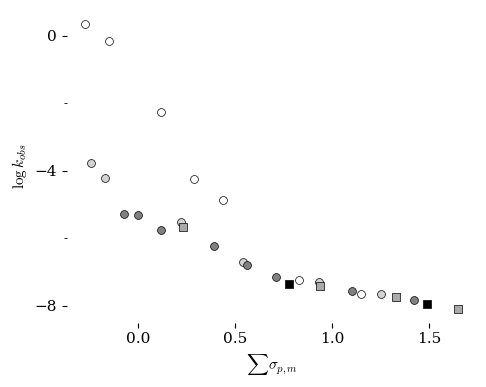

In [152]:
import scipy.stats as stats
from scipy.stats import linregress

OMe_df = df1.loc[(df1["para"]=="p-OCH3")]
Me_df = df1.loc[(df1["para"]=="p-CH3")]
H_df = df1.loc[(df1["para"]=="H")]
Br_df = df1.loc[(df1["para"]=="p-Br")]
NO2_df = df1.loc[(df1["para"]=="p-NO2")]

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)


df = OMe_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = Me_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="lightgray", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = H_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="gray", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = Br_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="darkgray", marker='s', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = NO2_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="black", marker='s', 
           edgecolor = "black", linewidth = 0.5, zorder=3)


ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sum \sigma_{p,m}$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
 #        xticks = [, 0.7, 1.4],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

#plt.plot(x,y, "ko")
#plt.axvline(x=0.32)

plt.savefig("plots/plot7.pdf")
plt.show()


## $\sum \sigma^{+}$ vs $\log{k_{obs}}$

All the data as a single series fit to the two-system model.


OMe -------------------
rho1: -1.41406+/-0.24661 
rho2: -7.75603+/-0.64667 
Power_divergenceResult(statistic=-1.3354707260921759, pvalue=1.0)


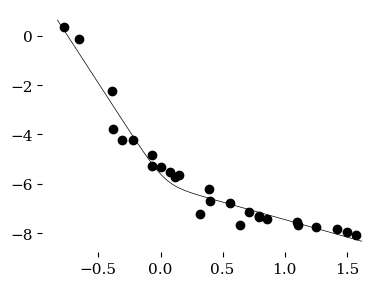

In [153]:
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
import uncertainties as un

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)

y = np.log10(df1["kobs"])
xm = df1["Total_meta_Sigma"]
xs = df1["Para_Sigma"]   # Also try "Total_Sigma"
xsp = df1["Para_Sigma_plus"]   # Also try "Total_Sigma"

x = xm + xs + 1.0*(xsp-xs)

x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 100)

plt.plot(x,y, "ko")

popt, pcov = curve_fit(addingHammett, x, y)
[rho1, int1, rho2, int2] = un.correlated_values(popt, pcov)

fity = addingHammett(x_span, *popt)
plt.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("OMe -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")

y_exp = addingHammett(x, *popt)
chisq = stats.chisquare(y, y_exp)
print(chisq)

## $\sum \sigma_{m,p}$ vs $\log{k_{obs}}$, Mechanism Sets

Plot of the $S_N1$ and $S_N2$ sets of data with fits to line or two-system model.


,Description,para,sub1,sub2,kobs,Total_Sigma,Total_Sigma_plus,Total_meta_Sigma,Total_meta_Sigma_plus,Para_Sigma,Para_Sigma_plus,MeOH/TFE,MeOH/H2O,H_2O/TFE
Designation,,,,,,,,,,,,,,
1-Cl,MeO-BnCl,p-OCH3,H,H,2.200000,-0.27,-0.78,0.00,0.00,-0.27,-0.78,26.0,13.0,2.0
MeO-1-Cl,MeO-MeO-BnCl,p-OCH3,m-OCH3,H,0.720000,-0.15,-0.66,0.12,0.12,-0.27,-0.78,26.0,16.0,1.6
Br-1-Cl,MeO-Br-BnCl,p-OCH3,m-Br,H,0.005700,0.12,-0.39,0.39,0.39,-0.27,-0.78,16.0,8.2,1.9
m-CN-1-Cl,MeO-CN-BnCl,p-OCH3,m-CN,H,0.000059,0.29,-0.22,0.56,0.56,-0.27,-0.78,8.7,3.8,2.3
NO2-1-Cl,MeO-NO2-BnCl,p-OCH3,m-NO2,H,0.000014,0.44,-0.07,0.71,0.71,-0.27,-0.78,8.7,3.6,2.4


Index(['1-Cl', 'MeO-1-Cl', 'Br-1-Cl', 'm-CN-1-Cl', 'NO2-1-Cl'], dtype='object', name='Designation')

NO2 -------------------
slope: -7.83279 +/- 0.57724
intercept: -1.55186 +/- 0.16070
rsq: 0.984
OMe -------------------
rho1: -3.72174+/-0.41590 
rho2: -0.91819+/-0.25960 


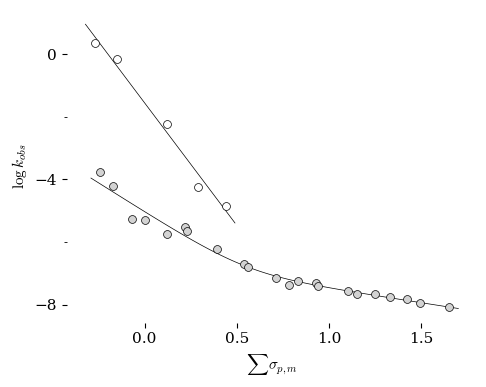

In [154]:
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
import uncertainties as un

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)

OMe_df = df1.loc[(df1["para"]=="p-OCH3")]
Me_df = df1.loc[(df1["para"]=="p-CH3")]
H_df = df1.loc[(df1["para"]=="H")]
Br_df = df1.loc[(df1["para"]=="p-Br")]
NO2_df = df1.loc[(df1["para"]=="p-NO2")]

df_temp = df1.loc[(df1["para"]=="p-OCH3")]
SN1_df = df_temp.loc[(df_temp["Total_meta_Sigma"] < 0.75)]
display(SN1_df)

mask = df1[(df1['para'] == 'p-OCH3') & (df1['Total_meta_Sigma'] < 0.75)].index
display(mask)
df_temp = df1.drop(mask , inplace=False)
SN2_df = df_temp

#df_temp = df1.loc[(df1["para"]!="p-OCH3")]
#SN2_df = df_temp
##SN2_df = df_temp.loc[(df_temp["Total_meta_Sigma"] > 0.75)]
#display(SN2_df)


plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

df = SN1_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 10)
ax.scatter(x,y, s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)
linfit = linregress(x,y)
fity = linfit.slope * x_span + linfit.intercept
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("NO2 -------------------")
print(f"slope: {linfit.slope:0.5f} +/- {linfit.stderr:0.5f}")
print(f"intercept: {linfit.intercept:0.5f} +/- {linfit.intercept_stderr:0.5f}")
print(f"rsq: {linfit.rvalue**2:0.3f}")


df = SN2_df
y = np.log10(df["kobs"])
x = df["Total_Sigma"]   # Also try "Total_Sigma"
x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 100)

ax.scatter(x,y, s=32, color="lightgray", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

popt, pcov = curve_fit(addingHammett, x, y)
[rho1, int1, rho2, int2] = un.correlated_values(popt, pcov)

fity = addingHammett(x_span, *popt)
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("OMe -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sum \sigma_{p,m}$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
 #        xticks = [, 0.7, 1.4],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

plt.savefig("plots/plot8.pdf")
plt.show()

## $\sum \sigma_{m,p}$ or $\sum \sigma^+$ vs $\log{k_{obs}}$, Mechanism Sets

Plot of the $S_N1$ and $S_N2$ sets of data with fits to line or two-system model. The data is plotted so that each data point is identified as being from a p-subsituent series.

Changing the column variable will change the sigma axis fom using $\sigma$ or $\sigma^+$.


SN1 -------------------
slope: -7.83279 +/- 0.57724
intercept: -5.54658 +/- 0.28855
rsq: 0.984
SN2 -------------------
rho1: -0.79010+/-0.32484 
rho2: -3.94632+/-0.95761 


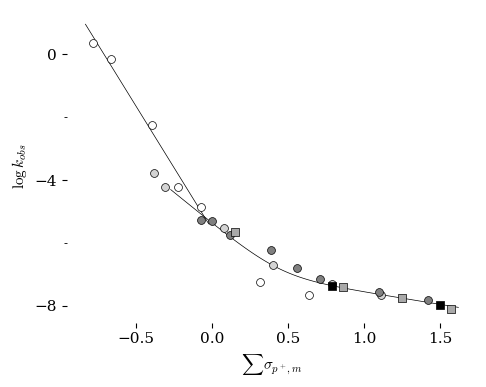

In [155]:
column = "Total_Sigma"    # for "plot8.pdf"
column = "Total_Sigma_plus"    # for "plot9.pdf"

import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit
from uncertainties import unumpy as unp
import uncertainties as un

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)

OMe_df = df1.loc[(df1["para"]=="p-OCH3")]
Me_df = df1.loc[(df1["para"]=="p-CH3")]
H_df = df1.loc[(df1["para"]=="H")]
Br_df = df1.loc[(df1["para"]=="p-Br")]
NO2_df = df1.loc[(df1["para"]=="p-NO2")]

df_temp = df1.loc[(df1["para"]=="p-OCH3")]
SN1_df = df_temp.loc[(df_temp["Total_meta_Sigma"] < 0.75)]
#display(SN1_df)

#mask = df1[(df1['para'] == 'p-OCH3') & (df1['Total_meta_Sigma'] < 0.75)].index

mask = df1[((df1['para'] == 'p-OCH3') & (df1['Total_meta_Sigma'] < 0.75)) | \
    ((df1['para'] == 'p-CH3') & (df1['Total_meta_Sigma'] < 0.1))].index

#display(mask)
df_temp = df1.drop(mask , inplace=False)
SN2_df = df_temp

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)


df = OMe_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = Me_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="lightgray", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = H_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="gray", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = Br_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="darkgray", marker='s', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

df = NO2_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
ax.scatter(x,y, s=32, color="black", marker='s', 
           edgecolor = "black", linewidth = 0.5, zorder=3)



df = SN1_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 10)
#ax.scatter(x,y, s=32, color="white", marker='o', 
#           edgecolor = "black", linewidth = 0.5, zorder=3)
linfit = linregress(x,y)
fity = linfit.slope * x_span + linfit.intercept
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("SN1 -------------------")
print(f"slope: {linfit.slope:0.5f} +/- {linfit.stderr:0.5f}")
print(f"intercept: {linfit.intercept:0.5f} +/- {linfit.intercept_stderr:0.5f}")
print(f"rsq: {linfit.rvalue**2:0.3f}")

df = SN2_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"

x_span = np.linspace(np.min(x)-0.2, np.max(x)+.05, 100)

#ax.scatter(x,y, s=32, color="lightgray", marker='o', 
#           edgecolor = "black", linewidth = 0.5, zorder=3)

popt, pcov = curve_fit(addingHammett, x, y)
[rho1, int1, rho2, int2] = un.correlated_values(popt, pcov)

fity = addingHammett(x_span, *popt)
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("SN2 -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")


#y = np.log10(df1["kobs"])
#xs = df1["Total_Sigma"]   # Also try "Total_Sigma"
#xsp = df1["Total_Sigma_plus"]   # Also try "Total_Sigma"
#x = xs + 1.5*(xsp-xs)



ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sum \sigma_{{p^+},m}$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
 #        xticks = [, 0.7, 1.4],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

#plt.axvline(x=0.32)

plt.savefig("plots/plot9.pdf")
plt.show()


## Yukawa Tsuno Optimization for $S_N1$

In the plot below I use the data associated with the $S_N1$ mechanism to optimize an r value for the YK plot of this mechanism. This is not robust, we are just finding a r value that move the OMe and the Me series until the line up.

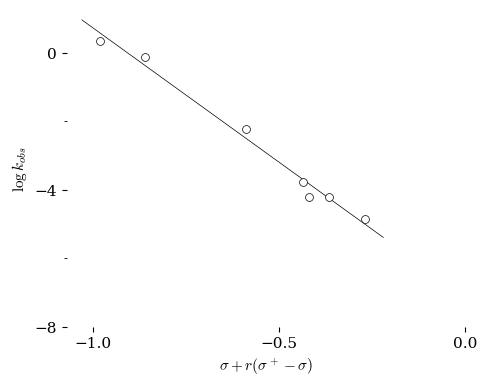

SN1 -------------------
slope: -7.84078 +/- 0.40946
intercept: -7.11504 +/- 0.25014
rsq: 0.987


In [156]:
column_s = "Total_Sigma"    # for "plot8.pdf"
column_sp = "Total_Sigma_plus"    # for "plot9.pdf"
r = 1.39



### SELECT DATA
 
SN1_df = df1[((df1['para'] == 'p-OCH3') & (df1['Total_meta_Sigma'] < 0.75)) 
    | ((df1['para'] == 'p-CH3') & (df1['Total_meta_Sigma'] < 0.1))]

mask = SN1_df.index
SN2_df = df1.drop(mask , inplace=False)

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

df = SN1_df
y = np.log10(df["kobs"])

s_m = df["Total_meta_Sigma"]
s_p = df["Para_Sigma"] + r*(df["Para_Sigma_plus"]-df["Para_Sigma"])

x = s_m + s_p   

x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 10)
ax.scatter(x,y, s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)
linfit = linregress(x,y)
fity = linfit.slope * x_span + linfit.intercept
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sigma + r(\sigma^+ - \sigma)$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         xticks = [-1, -0.5, 0],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

plt.savefig("plots/plot10.pdf")
plt.show()


print("SN1 -------------------")
print(f"slope: {linfit.slope:0.5f} +/- {linfit.stderr:0.5f}")
print(f"intercept: {linfit.intercept:0.5f} +/- {linfit.intercept_stderr:0.5f}")
print(f"rsq: {linfit.rvalue**2:0.3f}")


The optimal value for r is 1.398 for rsq = 0.98657


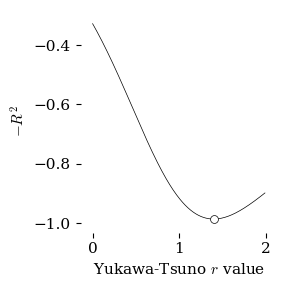

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.9865720330064502
       x: 1.3980443076910332
     nit: 11
    nfev: 14

In [157]:
from scipy.optimize import minimize_scalar
from scipy import stats

def RSQ_function(r):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    s_m = df["Total_meta_Sigma"]
    s_p = df["Para_Sigma"] + r*(df["Para_Sigma_plus"]-df["Para_Sigma"])

    x = s_m + s_p   
    linfit = linregress(x,y)
    return(-linfit.rvalue**2)

df = SN1_df
y = np.log10(df["kobs"])

##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-R^2$", 
       xlabel=r"Yukawa-Tsuno $r$ value")

rsq_range=[]
r_range = np.arange(0,2,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range, linewidth = 0.5)


##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {-r_opt['fun']:0.5f}")
ax.scatter(r_opt['x'],r_opt['fun'], s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)




plt.savefig("plots/plot10R.pdf")
plt.show()
r_opt

In [158]:
df1.head()

,Description,para,sub1,sub2,kobs,Total_Sigma,Total_Sigma_plus,Total_meta_Sigma,Total_meta_Sigma_plus,Para_Sigma,Para_Sigma_plus,MeOH/TFE,MeOH/H2O,H_2O/TFE
Designation,,,,,,,,,,,,,,
1-Cl,MeO-BnCl,p-OCH3,H,H,2.200000,-0.27,-0.78,0.00,0.00,-0.27,-0.78,26.0,13.0,2.0
MeO-1-Cl,MeO-MeO-BnCl,p-OCH3,m-OCH3,H,0.720000,-0.15,-0.66,0.12,0.12,-0.27,-0.78,26.0,16.0,1.6
Br-1-Cl,MeO-Br-BnCl,p-OCH3,m-Br,H,0.005700,0.12,-0.39,0.39,0.39,-0.27,-0.78,16.0,8.2,1.9
m-CN-1-Cl,MeO-CN-BnCl,p-OCH3,m-CN,H,0.000059,0.29,-0.22,0.56,0.56,-0.27,-0.78,8.7,3.8,2.3
NO2-1-Cl,MeO-NO2-BnCl,p-OCH3,m-NO2,H,0.000014,0.44,-0.07,0.71,0.71,-0.27,-0.78,8.7,3.6,2.4


SN2 -------------------
rho1: -0.51537+/-0.32138 
rho2: -2.79915+/-0.27466 


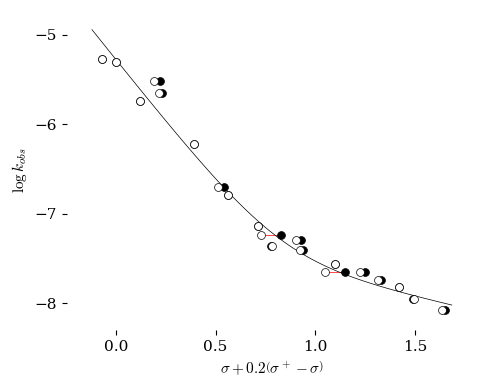

In [176]:
column_s = "Total_Sigma"   
column_sp = "Total_Sigma_plus"   

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)


################################################
### Data prep and calculations
################################################

r = 0.2

### copy data set and add columns for total YK value and log(k)
data = df1.copy()
data["YK"] = np.NaN
data["log"] = np.log10(data["kobs"])

### identify the data for the SN1 mechanism
mask = ((data['para'] == 'p-OCH3') & (data['Total_meta_Sigma'] < 0.75)) | \
    ((data['para'] == 'p-CH3') & (data['Total_meta_Sigma'] < 0.1))

### make new data frames for the points that ate SN1 and not SN1 (SN2)
SN2_df = data[~mask]  # the squiggle is boolean 'NOT' operator

### declare columns in data set to be used for s_m, s_p and s^+

sigma_plus_column = "Para_Sigma_plus"
sigma_column = "Para_Sigma"
sigma_m_column = "Total_meta_Sigma"

### calculate YK sigma value using YK r parameter for SN2
df = SN2_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r * (df[sigma_plus_column] - df[sigma_column]))
SN2_df = df.copy()

### Combine the SN1 and SN2 dataframes into a single dataframe
df_All = pd.concat([SN1_df, SN2_df])


################################################
### Create the plot object
################################################

style_file = "tufte.mplstyle"
plt.style.use(github_location_styles + style_file)        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

################################################
### Curve fit to model and plot line
################################################

x = df["YK"]  
y = np.log10(df["kobs"])

ax.scatter(x,y, s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

p0 = [-0, -7, -3, -5]
popt, pcov = curve_fit(addingHammett, x, y, p0 = p0)
[rho1, int1, rho2, int2] = un.correlated_values(popt, pcov)

x_span = np.linspace(np.min(x)-0.05, np.max(x)+.05, 100)
fity = addingHammett(x_span, *popt)
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("SN2 -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")



################################################
### Plot sum of sigma_para and _meta for r=0
################################################

s_m = df["Total_meta_Sigma"]
s_p = df["Para_Sigma"] + 0*(df["Para_Sigma_plus"]-df["Para_Sigma"])

x1 = s_m + s_p   

ax.scatter(x1,y, s=32, color="black", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=1)


################################################
### Decorations
################################################

ax.hlines(y, x, x1, color = "red", linewidth = 0.5, zorder = 0)


################################################
### Settings for plot
################################################

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sigma + 0.2\left(\sigma^+ - \sigma\right)$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         xticks = [0, 0.5, 1, 1.5],
         yticks = [-8,-7,-6,-5,-4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
#ax.set_yticks([-6,-2],minor=True)



################################################
### Output Plot
################################################

name = "plot11"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()



The optimal value for r is 0.208 for rsq = -0.98323


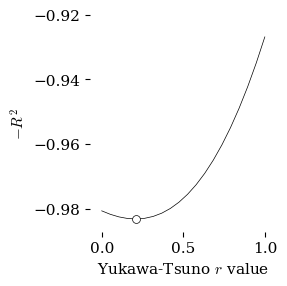

In [160]:
################################################
### PLOT OPTIMIZATION OF YK r VALUE FOR SN2 SET
################################################

from scipy.optimize import minimize_scalar

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)

def RSQ_function(r):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    s_m = df["Total_meta_Sigma"]
    s_p = df["Para_Sigma"] + r*(df["Para_Sigma_plus"]-df["Para_Sigma"])
    x = s_m + s_p   
    
    popt, pcov = curve_fit(addingHammett, x, y)
    y_calc = addingHammett(x, *popt)

    ### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    residuals = y-y_calc
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return(-r_squared)

################################################
### Create the plot object
################################################

style_file = "tufte.mplstyle"
plt.style.use(github_location_styles + style_file)        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

df = SN2_df
y = np.log10(df["kobs"])

rsq_range=[]
r_range = np.linspace(0,1,20)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range, linewidth = 0.5)


##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")

ax.scatter(r_opt['x'],r_opt['fun'], s=32, color="white", marker='o', 
           edgecolor = "black", linewidth = 0.5, zorder=3)

################################################
### Settings for plot
################################################

ax.set(
           ylabel=r"$-R^2$", 
           xlabel=r"Yukawa-Tsuno $r$ value",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7],
           xticks = [0, 0.5, 1],
           yticks = [-0.98,-0.96,-0.94,-0.92],
         )


################################################
### Output Plot
################################################

name = "plot11R"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()



r = 1.4 -------------------
slope: -7.81897 +/- 0.40797
intercept: -7.13445 +/- 0.25085
rsq: 0.987
r = 1.0 -------------------
slope: -8.18259 +/- 1.10384
intercept: -6.01598 +/- 0.50925
rsq: 0.917
r = 0.0 -------------------
slope: -4.27367 +/- 2.73905
intercept: -2.71905 +/- 0.71275
rsq: 0.327


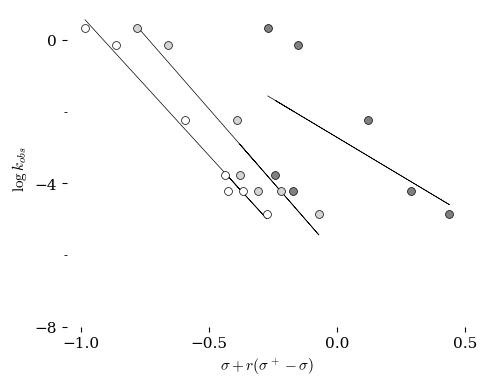

In [161]:
################################################
### PLOT YUKAWA-TSUNO PLOT WITH SPLIT r VALUES
################################################

################################################
### Data prep and calculations
################################################

### copy data set and add columns for total YK value and log(k)
data = df1.copy()

### identify the data for the SN1 mechanism
mask = ((data['para'] == 'p-OCH3') & (data['Total_meta_Sigma'] < 0.75)) | \
    ((data['para'] == 'p-CH3') & (data['Total_meta_Sigma'] < 0.1))

### make new data frames for the points that ate SN1 and not SN1 (SN2)
SN1_df = data[mask]


################################################
### Create the plot object
################################################

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

################################################
### Plot the data and line fit for multiple possible r values
################################################

df = SN1_df
y = np.log10(df["kobs"])

r_list = [1.4, 1.0, 0]
colors = ["white", "lightgray", "gray"]

for r, color in zip(r_list, colors):
    ### calculate sigma using YK r value
    s_m = df["Total_meta_Sigma"]
    s_p = df["Para_Sigma"] + r*(df["Para_Sigma_plus"]-df["Para_Sigma"])
    x = s_m + s_p   
    
    ### plot data for the give r value
    ax.scatter(x,y, s=32, color=color, marker='o', 
               edgecolor = "black", linewidth = 0.5, zorder=3)
    
    ### fit the data to linear function
    linfit = linregress(x,y)
    
    ### Plot the line
    fity = linfit.slope * x + linfit.intercept
    ax.plot(x, fity, color='black', zorder=1, linewidth=0.5)
    
    print(f"r = {r:3.1f} -------------------")
    print(f"slope: {linfit.slope:0.5f} +/- {linfit.stderr:0.5f}")
    print(f"intercept: {linfit.intercept:0.5f} +/- {linfit.intercept_stderr:0.5f}")
    print(f"rsq: {linfit.rvalue**2:0.3f}")


################################################
### Settings for plot
################################################

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sigma + r(\sigma^+ - \sigma)$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
         xticks = [-1, -.5, 0, .5],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)


################################################
### Output Plot
################################################

name = "plot10_multiR"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()



SN1 -------------------
slope: -7.81897 +/- 0.40797
intercept: -7.13445 +/- 0.25085
rsq: 0.9866
SN2 -------------------
rho1: -0.51537+/-0.32138 
rho2: -2.79915+/-0.27466 
RSQ = 0.9832


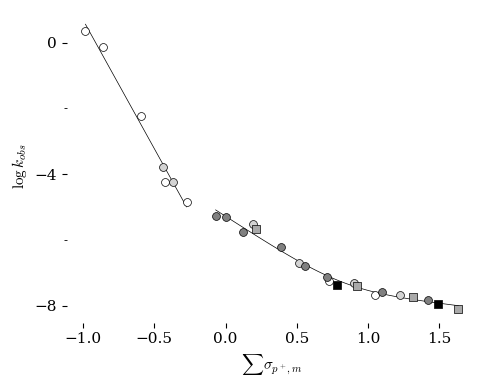

In [162]:
################################################
### PLOT YUKAWA-TSUNO PLOT WITH SPLIT r VALUES
################################################

################################################
### Data prep and calculations
################################################

r1 = 1.4
r2 = 0.2

### copy data set and add columns for total YK value and log(k)
data = df1.copy()
data["YK"] = np.NaN
data["log"] = np.log10(data["kobs"])

### identify the data for the SN1 mechanism
mask = ((data['para'] == 'p-OCH3') & (data['Total_meta_Sigma'] < 0.75)) | \
    ((data['para'] == 'p-CH3') & (data['Total_meta_Sigma'] < 0.1))

### make new data frames for the points that ate SN1 and not SN1 (SN2)
SN1_df = data[mask]
SN2_df = data[~mask]  # the squiggle is boolean 'NOT' operator

### declare columns in data set to be used for s_m, s_p and s^+

sigma_plus_column = "Para_Sigma_plus"
sigma_column = "Para_Sigma"
sigma_m_column = "Total_meta_Sigma"

### calculate YK sigma value using YK r parameter for SN1
df = SN1_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r1 * (df[sigma_plus_column] - df[sigma_column]))
SN1_df = df.copy()

### calculate YK sigma value using YK r parameter for SN2
df = SN2_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r2 * (df[sigma_plus_column] - df[sigma_column]))
SN2_df = df.copy()

### Combine the SN1 and SN2 dataframes into a single dataframe
df_All = pd.concat([SN1_df, SN2_df])

################################################
### Define function for model
################################################

def addingHammett(x, rho1, int1, rho2, int2):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_combined = np.log10(10**y_rx1+10**y_rx2)
    return(y_combined)


################################################
### Create the plot object
################################################

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

################################################
### Plot the data points for the five series
################################################

series = ["p-OCH3", "p-CH3", "H", "p-Br", "p-NO2"]
colors = ["white", "lightgray", "gray", "darkgray", "black"]
shapes = ["o", "o", "o", "s", "s"]

column = "YK"    
for ser,col,sh in zip(series,colors,shapes):
    df = df_All.loc[(df1["para"] == ser)]     # get only row for a given series
    y = np.log10(df["kobs"])              # get y values
    x = df[column]   # Also try "Total_Sigma" # get x values
    ax.scatter(x,y, s=32,                     # plot the data for a series using
               color=col, marker=sh,          #  the color and style chosen
               edgecolor = "black", linewidth = 0.5, 
               zorder=3)


################################################
### Curve fit to linear function and plot line
################################################

df = SN1_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"
x_span = np.linspace(np.min(x), np.max(x), 10)

linfit = linregress(x,y)
fity = linfit.slope * x_span + linfit.intercept
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)

print("SN1 -------------------")
print(f"slope: {linfit.slope:0.5f} +/- {linfit.stderr:0.5f}")
print(f"intercept: {linfit.intercept:0.5f} +/- {linfit.intercept_stderr:0.5f}")
print(f"rsq: {linfit.rvalue**2:0.4f}")


################################################
### Curve fit to model function and plot line
################################################

df = SN2_df
y = np.log10(df["kobs"])
x = df[column]   # Also try "Total_Sigma"

x_span = np.linspace(np.min(x), np.max(x), 100)

p0 = [-0, -7, -3, -5]
popt, pcov = curve_fit(addingHammett, x, y, p0 = p0)
[rho1, int1, rho2, int2] = un.correlated_values(popt, pcov)

fity = addingHammett(x_span, *popt)
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("SN2 -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")

################################################
### Calculate RSQ for data and plot
################################################

y_calc = addingHammett(x, *popt)

### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
residuals = y-y_calc
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"RSQ = {r_squared:0.4f}")


################################################
### Settings for plot
################################################

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$\sum \sigma_{{p^+},m}$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
 #        xticks = [, 0.7, 1.4],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

################################################
### Output Plot
################################################

name = "plot9"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()


SN2 -------------------
rho1: -8.35452+/-0.46316 
rho2: -2.44166+/-0.29238 
rho3: -0.29137+/-0.62043 


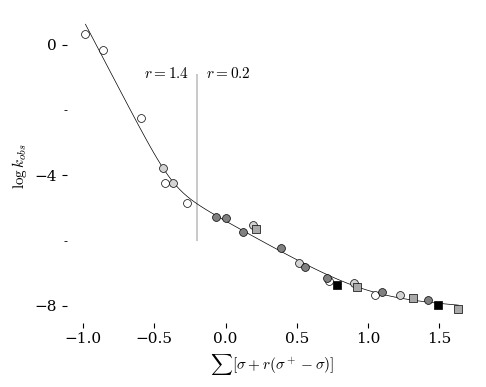

RSQ = 0.9941


In [163]:
################################################
### PLOT YUKAWA-TSUNO PLOT WITH SPLIT r VALUES
################################################


################################################
### Data prep and calculations
################################################

r1 = 1.4
r2 = 0.2

### copy data set and add columns for total YK value and log(k)
data = df1.copy()
data["YK"] = np.NaN
data["log"] = np.log10(data["kobs"])

### identify the data for the SN1 mechanism
mask = ((data['para'] == 'p-OCH3') & (data['Total_meta_Sigma'] < 0.75)) | \
    ((data['para'] == 'p-CH3') & (data['Total_meta_Sigma'] < 0.1))

### make new data frames for the points that ate SN1 and not SN1 (SN2)
SN1_df = data[mask]
SN2_df = data[~mask]  # the squiggle is boolean 'NOT' operator

### declare columns in data set to be used for s_m, s_p and s^+

sigma_plus_column = "Para_Sigma_plus"
sigma_column = "Para_Sigma"
sigma_m_column = "Total_meta_Sigma"

### calculate YK sigma value using YK r parameter for SN1
df = SN1_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r1 * (df[sigma_plus_column] - df[sigma_column]))
SN1_df = df.copy()

### calculate YK sigma value using YK r parameter for SN2
df = SN2_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r2 * (df[sigma_plus_column] - df[sigma_column]))
SN2_df = df.copy()

### Combine the SN1 and SN2 dataframes into a single dataframe
df_All = pd.concat([SN1_df, SN2_df])

################################################
### Define function for model
################################################

def addingHammett(x, rho1, int1, rho2, int2, rho3, int3):
    y_rx1 = rho1*x + int1
    y_rx2 = rho2*x + int2
    y_rx3 = rho3*x + int3
    y_combined = np.log10(10**y_rx1+10**y_rx2+10**y_rx3)
    return(y_combined)


################################################
### Create the plot object
################################################

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

################################################
### Plot the data points for the five series
################################################

series = ["p-OCH3", "p-CH3", "H", "p-Br", "p-NO2"]
colors = ["white", "lightgray", "gray", "darkgray", "black"]
shapes = ["o", "o", "o", "s", "s"]

column = "YK"    
for ser,col,sh in zip(series,colors,shapes):
    df = df_All.loc[(df1["para"] == ser)]     # get only row for a given series
    y = np.log10(df["kobs"])              # get y values
    x = df[column]   # Also try "Total_Sigma" # get x values
    ax.scatter(x,y, s=32,                     # plot the data for a series using
               color=col, marker=sh,          #  the color and style chosen
               edgecolor = "black", linewidth = 0.5, 
               zorder=3)

################################################
### Curve fit to model function and plot line
################################################

df = df_All.copy()
y = np.log10(df["kobs"])
x = df[column]   

x_span = np.linspace(np.min(x), np.max(x), 100) # many x points for smooth line

p0 = [-8.4, -7.6, -2.4, -5.4, -0.3, -7.5]       # initial values for fit
popt, pcov = curve_fit(addingHammett, x, y, p0 = p0)

### convert fit parameters and covariance matrix into a set of correlated
###  uncertain values
[rho1, int1, rho2, int2, rho3, int3] = un.correlated_values(popt, pcov)

fity = addingHammett(x_span, *popt)
ax.plot(x_span, fity, color='black', zorder=1, linewidth=0.5)
print("SN2 -------------------")
print(f"rho1: {rho1:0.5f} ")
print(f"rho2: {rho2:0.5f} ")
print(f"rho3: {rho3:0.5f} ")

################################################
### Settings for plot
################################################

ax.set(
#    title="Initial Rate Log-Log Plot",       
          ylabel=r"$\log{k_{obs}}$", 
        xlabel=r"$\sum \left[ \sigma + r(\sigma^+ - \sigma)\right]$",                
#          xlim=[-.9,.9],                  
#          ylim=[-3.7,-2.7]
 #        xticks = [, 0.7, 1.4],
         yticks = [-8, -4, 0],
         )
#ax.set_xticks([0.35,1.05],minor=True)
ax.set_yticks([-6,-2],minor=True)

################################################
### Decorations
################################################

ax.vlines(-0.2,-6,-0.9, linewidth = 0.3)
ax.text(-0.57,-1,r"$r = 1.4$")
ax.text(-0.14,-1,r"$r = 0.2$")

################################################
### Output Plot
################################################

name = "plot12"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()

################################################
### Calculate RSQ for data and plot
################################################

y_calc = addingHammett(x, *popt)

### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
residuals = y-y_calc
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"RSQ = {r_squared:0.4f}")

#display(df_All.head())

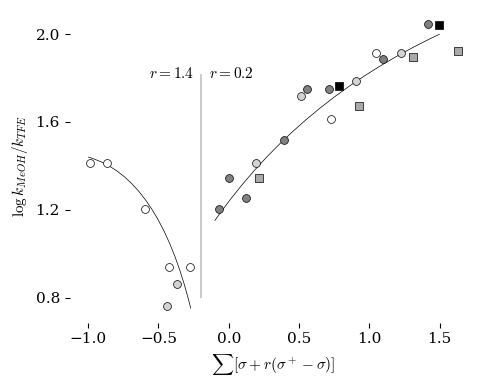

In [164]:
################################################
### PLOT PRODUCT RATIOS vs YK SIGMA VALUES
################################################

################################################
### Data prep and calculations
################################################

### copy data set and add columns for total YK value and log(k)
data = df1.copy()
data["YK"] = np.NaN
data["log"] = np.log10(data["kobs"])

### identify the data for the SN1 mechanism
mask = ((data['para'] == 'p-OCH3') & (data['Total_meta_Sigma'] < 0.75)) | \
    ((data['para'] == 'p-CH3') & (data['Total_meta_Sigma'] < 0.1))

### make new data frames for the points that ate SN1 and not SN1 (SN2)
SN1_df = data[mask]
SN2_df = data[~mask]  # the squiggle is boolean 'NOT' operator

### declare columns in data set to be used for s_m, s_p and s^+

sigma_plus_column = "Para_Sigma_plus"
sigma_column = "Para_Sigma"
sigma_m_column = "Total_meta_Sigma"

### calculate YK sigma value using YK r parameter for SN1
r = 1.4
df = SN1_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r * (df[sigma_plus_column] - df[sigma_column]))
SN1_df = df.copy()

### calculate YK sigma value using YK r parameter for SN2
r = 0.2
df = SN2_df.copy()
df["YK"] = df[sigma_m_column] + (df[sigma_column] \
                + r * (df[sigma_plus_column] - df[sigma_column]))
SN2_df = df.copy()

### Combine the SN1 and SN2 dataframes into a single dataframe
df_All = pd.concat([SN1_df, SN2_df])

################################################
### Create the plot object
################################################

plt.style.use(github_location_styles + "tufte.mplstyle")        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.05, y=.05, tight=True)

################################################
### Plot the data points for the five series
################################################

series = ["p-OCH3", "p-CH3", "H", "p-Br", "p-NO2"]
colors = ["white", "lightgray", "gray", "darkgray", "black"]
shapes = ["o", "o", "o", "s", "s"]

column = "YK"    
for ser,col,sh in zip(series,colors,shapes):
    df = df_All.loc[(df1["para"] == ser)]     # get only row for a given series
    y = np.log10(df["MeOH/TFE"])              # get y values
    x = df[column]   # Also try "Total_Sigma" # get x values
    ax.scatter(x,y, s=32,                     # plot the data for a series using
               color=col, marker=sh,          #  the color and style chosen
               edgecolor = "black", linewidth = 0.5, 
               zorder=3)


################################################
### Decorations
################################################

### divider line for YK r values
ax.vlines(-0.2, 0.8,1.82, linewidth = 0.3)
ax.text(-0.57, 1.8,r"$r = 1.4$")
ax.text(-0.14,1.8,r"$r = 0.2$")

### Add curved lines to highlight trends - these are NOT line fits
beziers = [[(-1, 1.44), (-0.5, 1.35), (-0.27, .75)],   # nodes for path 
        [(-0.1, 1.15), (0.5, 1.7), (1.5, 2.0)]]        # nodes for other path
commands = [Path.MOVETO, Path.CURVE3, Path.CURVE3]     # must match # of nodes

for b in beziers:
    pp1 = mpatches.PathPatch(mpath.Path(b,commands),
                             fc="none",                # no fill color
                     #        transform=ax.transData, 
                             linewidth=0.5, 
                             zorder = 0)
    ax.add_patch(pp1)

################################################
### Settings for plot
################################################

ax.set(
        ylabel=r"$\log{k_{MeOH}/k_{TFE}}$", 
        xlabel=r"$\sum \left[ \sigma + r(\sigma^+ - \sigma)\right]$",                
#        xlim=[-.9,.9],                  
#        ylim=[-3.7,-2.7]
#        xticks = [, 0.7, 1.4],
        yticks = [0.8,1.2,1.6,2.0],
         )

################################################
### Output Plot
################################################

name = "plot13"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()